# Text Classification w. MLPs

> *Text Analytics*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

Develop a sentiment classifier for a kind of texts of your choice (e.g., tweets, product or movie reviews). Use an existing sentiment analysis dataset with at least two classes (e.g., positive/negative or positive/negative/neutral). The classes should be mutually exclusive, i.e., this is a single-label multi-class classification problem.

Repeat the project implemented in ***text_classification_with_basic_models*** repository, now using an MLP classifier implemented in Keras/TensorFlow or PyTorch. Tune the hyper-parameters (e.g., number of hidden layers, dropoit probability) on the development subset of your dataset. Monitor the performance of the MLP during training to decide how many epochs to use. Include experimental results of a baseline majority classifier, as well as experimental results of the best classifier from ***text_classification_with_basic_models*** repository, now treated as a second baseline. For each classifier:


- Calculate (macro-averaged) precision, recall, F1 both for the training and test subsets
- Calculate and plot the confusion matrices both for the training and test subsets
- Calculate and plot the precision-recall AUC scores both for the training and test subsets
- Calculate and plot the curves showing the accuracy and loss on training data as a function of epochs

## Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import string
import re
import contractions

import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    plot_confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    roc_curve, 
    auc
)
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
from tabulate import tabulate
import time
from datetime import datetime

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from tensorflow.keras.layers import InputLayer
from sklearn.preprocessing import LabelBinarizer
from keras import backend

## Data

- The data were acquired from [kaggle](https://www.kaggle.com/competitions/tweet-sentiment-extraction/data) 
- This is a dataset for sentiment classification which contains 27K tweets for training and 3.5K tweets for testing
- The reviews are labelled positive, negative or neutral

##### *Import the data*

In [2]:
# load train and test set
train_data = pd.read_csv("./Data/train.csv")
test_data = pd.read_csv("./Data/test.csv")

#convert tweets to string
train_data.text = train_data.text.astype(str)
test_data.text = test_data.text.astype(str)

## Descriptive Statistics

In [3]:
def descriptive_statistics(df):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # get the vocabulary size
    # aka number of unique words appeared in the reviews
    vocabulary_size = len(list(set(' '.join(df.text).split())))

    # get the length of each review
    df['tweet_length'] = df.text.apply(lambda x: len(x))

    # get the avg, min, max review length (overall)
    avg_len = int(np.mean(df.tweet_length))
    min_len = df.tweet_length.min()
    max_len = df.tweet_length.max()

    # get the avg, min, max review length (positive class)
    avg_len_pos = int(np.mean(df[df.sentiment == 'positive'].tweet_length))
    min_len_pos = df[df.sentiment == 'positive'].tweet_length.min()
    max_len_pos = df[df.sentiment == 'positive'].tweet_length.max()

    # get the avg, min, max review length (neutral class)
    avg_len_nt = int(np.mean(df[df.sentiment == 'neutral'].tweet_length))
    min_len_nt = df[df.sentiment == 'neutral'].tweet_length.min()
    max_len_nt = df[df.sentiment == 'neutral'].tweet_length.max()

    # get the avg, min, max review length (negative class)
    avg_len_neg = int(np.mean(df[df.sentiment == 'negative'].tweet_length))
    min_len_neg = df[df.sentiment == 'negative'].tweet_length.min()
    max_len_neg = df[df.sentiment == 'negative'].tweet_length.max()

    print('='*120)
    print('Vocabulary', end='\n\n')
    print(f'There are {vocabulary_size} unique words.')
    print('='*120)
    print('Tweet Statistics', end='\n\n')
    print(f'Positive Reviews')
    print(f'- Average Length: {avg_len_pos}')
    print(f'- Minimum Length: {min_len_pos}')
    print(f'- Maximum Length: {max_len_pos}', end='\n\n')
    print(f'Neutral Reviews')
    print(f'- Average Length: {avg_len_nt}')
    print(f'- Minimum Length: {min_len_nt}')
    print(f'- Maximum Length: {max_len_nt}', end='\n\n')
    print(f'Negative Reviews')
    print(f'- Average Length: {avg_len_neg}')
    print(f'- Minimum Length: {min_len_neg}')
    print(f'- Maximum Length: {max_len_neg}', end='\n\n')
    print('='*120)

    # create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), dpi=100, facecolor='white')

    # plot positive reviews length distribution
    sns.kdeplot(x=df[df.sentiment == 'positive'].tweet_length, shade=True, color='navy', ax=ax1)
    ax1.axvline(avg_len_pos, linestyle='--', color='black')
    ax1.set_xlabel('Words')
    ax1.set_ylabel(None)
    ax1.set_yticks([])
    ax1.set_title('Positive Tweets Length Distribution')

    # plot neutral reviews length distribution
    sns.kdeplot(x=df[df.sentiment == 'neutral'].tweet_length, shade=True, color='gray', ax=ax2)
    ax2.axvline(avg_len_nt, linestyle='--', color='black')
    ax2.set_xlabel('Words')
    ax2.set_ylabel(None)
    ax2.set_yticks([])
    ax2.set_title('Neutral Tweets Length Distribution')

    # plot negative reviews length distribution
    sns.kdeplot(x=df[df.sentiment == 'negative'].tweet_length, shade=True, color='green', ax=ax3)
    ax3.axvline(avg_len_neg, linestyle='--', color='black')
    ax3.set_xlabel('Words')
    ax3.set_ylabel(None)
    ax3.set_yticks([])
    ax3.set_title('Negative Tweets Length Distribution')

    plt.tight_layout(pad=3)
    plt.show()

    return

Vocabulary

There are 52270 unique words.
Tweet Statistics

Positive Reviews
- Average Length: 70
- Minimum Length: 5
- Maximum Length: 138

Neutral Reviews
- Average Length: 65
- Minimum Length: 3
- Maximum Length: 141

Negative Reviews
- Average Length: 70
- Minimum Length: 5
- Maximum Length: 141



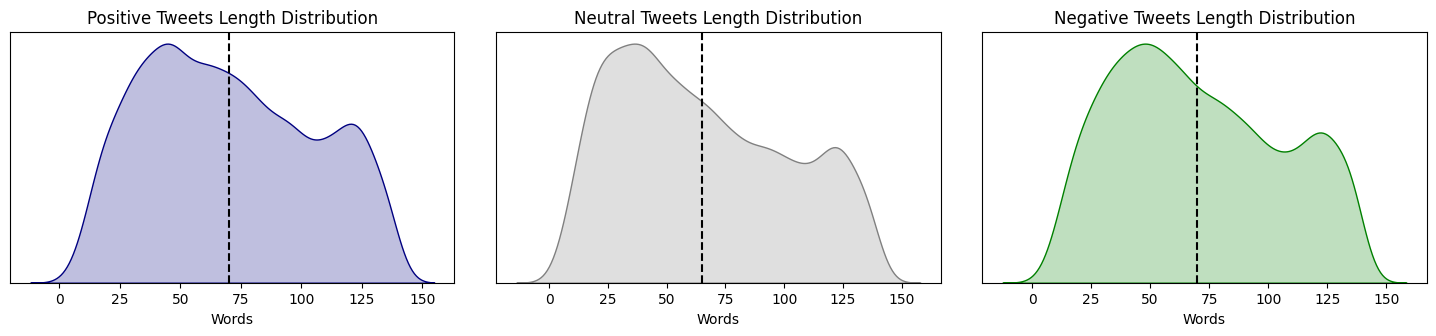

Vocabulary

There are 11612 unique words.
Tweet Statistics

Positive Reviews
- Average Length: 68
- Minimum Length: 6
- Maximum Length: 142

Neutral Reviews
- Average Length: 65
- Minimum Length: 4
- Maximum Length: 138

Negative Reviews
- Average Length: 69
- Minimum Length: 8
- Maximum Length: 138



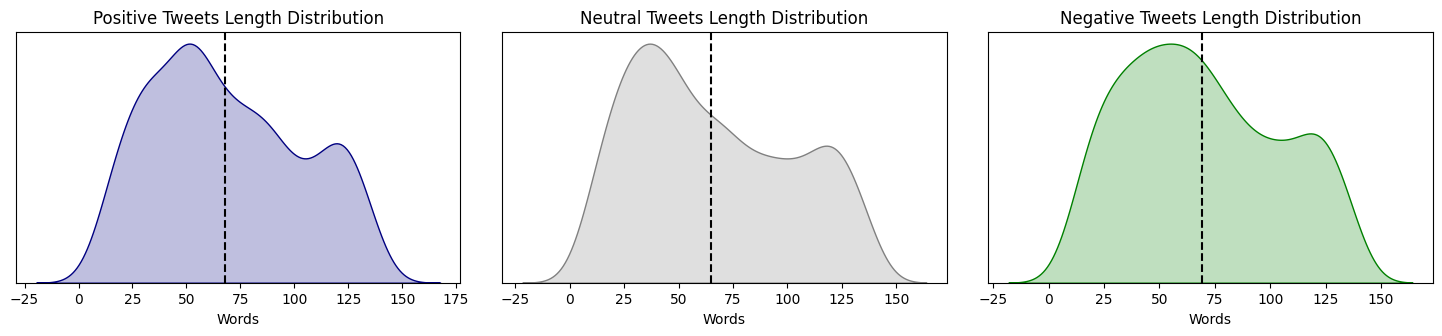

In [4]:
# print statistics for the training and test sets

_ = descriptive_statistics(train_data)
_ = descriptive_statistics(test_data)

## Data Processing

- We will apply the following processing steps to the tweets:
    - Remove non-word characters (special characters, punctuation)
    - Expand contractions
    - Remove single characters surrounded by spaces
    - Replace multiple spaces with a single space, ignoring case
    - Convert to lowercase
    - Remove stopwords
    - Perform stemming
    
##### *Define function to clean and preprocess the tweets*

In [5]:
def preprocessText(corpus):
    # Initialize WordNet lemmatizer
    stemmer = WordNetLemmatizer()
    # List to store preprocessed documents
    docs = []

    # Iterate over each document in the corpus
    for doc in corpus:
        # Remove non-word characters (special characters, punctuation)
        document = re.sub(r'\W', ' ', str(doc))
        # expand contractions
        document = contractions.fix(document)
        # Remove single characters surrounded by spaces
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        # Replace multiple spaces with a single space, ignoring case
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        # Convert the document to lowercase
        document = document.lower()
        # Tokenize the document into words
        document = document.split()
        # remove stopwords
        document = [word for word in document if word not in stopwords.words('english')]
        # Lemmatize each word in the document
        document = [stemmer.lemmatize(word) for word in document]
        # Join the lemmatized words back into a string
        document = ' '.join(document)
        # Append the preprocessed document to the list
        docs.append(document)

    # Return the list of preprocessed documents
    return docs

In [6]:
train_data['processed_Text'] = preprocessText(train_data.text.to_list())
test_data['processed_Text'] = preprocessText(test_data.text.to_list())

## Train Development Test Split

In [7]:
x_train, x_dev, y_train, y_dev = train_test_split(train_data.processed_Text, train_data.sentiment, 
                                                  test_size=0.2, random_state=1234)
x_test,y_test = test_data.processed_Text, test_data.sentiment

print('='*30)
print('Training Set Size: ', x_train.shape[0])
print('Development Set Size: ', x_dev.shape[0])
print('Test Set Size: ', x_test.shape[0])
print('='*30)

Training Set Size:  21984
Development Set Size:  5497
Test Set Size:  3534


## Text Vectorization

- The next step is to vectorize the tweets into term-document matrices using TF-IDF
- TF-IDF is a measure that quantifies the importance or relevance of string representations in a document amongst a collection of documents (aka corpus)
- In our case, we will extract the vectors for both unigrams and bigrams and consider only the top $5000$ features
- Finally, we will apply sublinear tf scaling, i.e. replace tf with $1 + log(tf)$ (converting tf-idf to wf-idf)

##### *Define a function to perform text vectorization*

In [8]:
def text_vectorization(x_train, x_dev, x_test):

    # initialize the TFIDF vectorizer
    vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000, sublinear_tf=True)
    
    # vectorize the reviews in train and test sets
    x_train_tfidf = vectorizer.fit_transform(x_train)
    x_dev_tfidf = vectorizer.transform(x_dev)
    x_test_tfidf = vectorizer.transform(x_test)

    return x_train_tfidf, x_dev_tfidf, x_test_tfidf

# execute function
x_train_tfidf, x_dev_tfidf, x_test_tfidf = text_vectorization(x_train, x_dev, x_test)

## Dimensionality Reduction

- In addition, we will perform dimensionality reduction on the vectors generated from the previous step to reduce the number of features
- In particular, we will use the Truncated SVD transformer which performs linear dimensionality reduction and works well with sparse matrices
- Due to time and resource limitations, we will reduce the dimensionality to $2000$ features
- This results in an explained variance ratio of $82\%$ of our initial feature vectors

##### *Define a function to perform dimensionality reduction*

In [9]:
def dimensionality_reduction(x_train_tfidf, x_valid_tfidf, x_test_tfidf,n_components = 2000):

    # initialize the truncated SVD transformer
    svd = TruncatedSVD(n_components=n_components, random_state=123)

    # decompose the values
    # in training, validation and test sets
    x_train_svd = svd.fit_transform(x_train_tfidf)
    x_valid_svd = svd.transform(x_valid_tfidf)
    x_test_svd = svd.transform(x_test_tfidf)

    # print the explained variance ratio
    print(f'Explained variance ratio with {n_components} components is {svd.explained_variance_ratio_.sum():.3}.', end='\n\n')

    return x_train_svd, x_valid_svd, x_test_svd


x_train_svd, x_dev_svd, x_test_svd = dimensionality_reduction(x_train_tfidf, x_dev_tfidf, x_test_tfidf)

Explained variance ratio with 2000 components is 0.82.



## Sentiment Classification

- We begin by defining functions to print the classification results

In [12]:
def calculate_scores(y_actual, y_pred, y_pred_proba):
    # Define the labels for the classes
    _labels = ['positive', 'neutral', 'negative']
    
    # Initialize dictionaries to store precision, recall, f1, and AUC scores
    precision_dict = dict()
    recall_dict = dict()
    f1_dict = dict()
    auc_score = dict()
    
    # Calculate precision, recall, f1, and support for each class
    precision, recall, f1, support = precision_recall_fscore_support(y_actual, y_pred, average=None, labels=_labels)
    
    # Populate dictionaries with scores for each class
    for index, value in enumerate(_labels):
        precision_dict[value] = precision[index]
        recall_dict[value] = recall[index]
        f1_dict[value] = f1[index]
    
    # Calculate AUC score for each class and macro-average
    auc_score = calculate_auc_score(_labels, y_actual, y_pred_proba)
    auc_score['macro'] = calculate_auc_score(_labels, y_actual, y_pred_proba, 'macro')
    
    # Calculate macro-averaged precision, recall, f1, and support
    precision_dict["macro"], recall_dict["macro"], f1_dict["macro"], support_macro = \
        precision_recall_fscore_support(y_actual, y_pred, average='macro', labels=_labels)
    
    # Create a DataFrame to store the scores
    scores_df = pd.DataFrame.from_dict({'precision': precision_dict, 'recall': recall_dict, 'f1': f1_dict, 'auc_score': auc_score})
    
    return scores_df

def calculate_auc_score(labels, y_true, y_pred_proba, average=None):
    # Dictionary to store ROC AUC scores for each class
    roc_auc_ovr = {}

    # Iterate over each class
    for i in range(len(labels)):
        c = labels[i]
        
        # Create a DataFrame for the binary classification of the current class
        df_aux = pd.DataFrame()
        df_aux['class'] = [1 if y == c else 0 for y in y_true]
        df_aux['prob'] = y_pred_proba[:, i]
        df_aux = df_aux.reset_index(drop=True)
        
        # Calculate ROC AUC score for the current class
        if average == 'macro':
            return roc_auc_score(df_aux['class'], df_aux['prob'], average=average)
        else:
            roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'], average=average)

    return roc_auc_ovr

def plot_confusion_matrix(estimator_model, X_test, y_test, estimator_name):
    # Set labels for the confusion matrix
    estimator_model.labels = estimator_model.classes_

    # Confusion matrix for test set
    fig, ax = plt.subplots(figsize=(6, 6))
    
    disp = plot_confusion_matrix(estimator_model, X_test, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax)
    disp.ax_.set_title(f'Confusion Matrix - {estimator_name} (Test Set)')

    plt.show()


def print_scores(estimator_model, estimator_name, X_train, y_train, X_dev, y_dev, X_test, y_test):
    # Predictions and probabilities for the training set
    y_pred_train = estimator_model.predict(X_train)
    y_pred_proba_train = estimator_model.predict_proba(X_train)
    
    # Calculate and print scores for the training set
    scores_train = calculate_scores(y_train, y_pred_train, y_pred_proba_train)
    print("Trainset Results in {}".format(estimator_name))
    print(tabulate(scores_train.round(3), headers='keys', tablefmt='psql'))
    print("=" * 100)

    if len(y_dev) > 0:
        
        # Predictions and probabilities for the development set
        y_pred_dev = estimator_model.predict(X_dev)
        y_pred_proba_dev = estimator_model.predict_proba(X_dev)
    
        # Calculate and print scores for the development set
        scores_dev = calculate_scores(y_dev, y_pred_dev, y_pred_proba_dev)
        print("Devset Results in {}".format(estimator_name))
        print(tabulate(scores_dev.round(3), headers='keys', tablefmt='psql'))
        print("=" * 100)

    # Predictions and probabilities for the test set
    y_pred_test = estimator_model.predict(X_test)
    y_pred_proba_test = estimator_model.predict_proba(X_test)
    
    # Calculate and print scores for the test set
    scores_test = calculate_scores(y_test, y_pred_test, y_pred_proba_test)
    print("Testset Results in {}".format(estimator_name))
    print(tabulate(scores_test.round(3), headers='keys', tablefmt='psql'))
    
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred_test, labels=estimator_model.classes_)

    # Create heatmap
    plt.figure(figsize=(4,4), dpi = 90,facecolor='white')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=estimator_model.classes_, yticklabels=estimator_model.classes_)
    plt.title(f'Confusion Matrix - {estimator_name} (Test Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    plt.show()

##### *Concatenate training and validation subsets*

In [11]:
x_train_concat = np.concatenate((x_train_svd, x_dev_svd))
y_train_concat = np.concatenate((y_train, y_dev))

# pass the values in a dictionary
#sets = {'train': [x_train_concat, y_train_concat], 'test': [x_test_svd, y_test]}

## Baseline Results

##### *Run experimental results using:*

- Baseline dummy classifier
- Best performing classifier from *text_classification_with_basic_models* repository

Trainset Results in DummyClassifier
+----------+-------------+----------+-------+-------------+
|          |   precision |   recall |    f1 |   auc_score |
|----------+-------------+----------+-------+-------------|
| positive |       0     |    0     | 0     |         0.5 |
| neutral  |       0.405 |    1     | 0.576 |         0.5 |
| negative |       0     |    0     | 0     |         0.5 |
| macro    |       0.135 |    0.333 | 0.192 |         0.5 |
+----------+-------------+----------+-------+-------------+
Testset Results in DummyClassifier
+----------+-------------+----------+-------+-------------+
|          |   precision |   recall |    f1 |   auc_score |
|----------+-------------+----------+-------+-------------|
| positive |       0     |    0     | 0     |         0.5 |
| neutral  |       0.405 |    1     | 0.576 |         0.5 |
| negative |       0     |    0     | 0     |         0.5 |
| macro    |       0.135 |    0.333 | 0.192 |         0.5 |
+----------+-------------+---

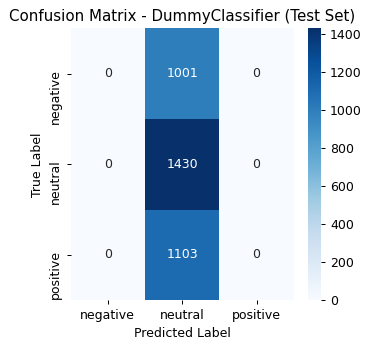

Trainset Results in LightGBM
+----------+-------------+----------+-------+-------------+
|          |   precision |   recall |    f1 |   auc_score |
|----------+-------------+----------+-------+-------------|
| positive |       0.989 |    0.978 | 0.983 |       0.128 |
| neutral  |       0.967 |    0.99  | 0.979 |       0.996 |
| negative |       0.992 |    0.971 | 0.981 |       0.168 |
| macro    |       0.983 |    0.979 | 0.981 |       0.128 |
+----------+-------------+----------+-------+-------------+
Testset Results in LightGBM
+----------+-------------+----------+-------+-------------+
|          |   precision |   recall |    f1 |   auc_score |
|----------+-------------+----------+-------+-------------|
| positive |       0.772 |    0.694 | 0.731 |       0.167 |
| neutral  |       0.623 |    0.741 | 0.677 |       0.786 |
| negative |       0.697 |    0.587 | 0.637 |       0.203 |
| macro    |       0.697 |    0.674 | 0.682 |       0.167 |
+----------+-------------+----------+------

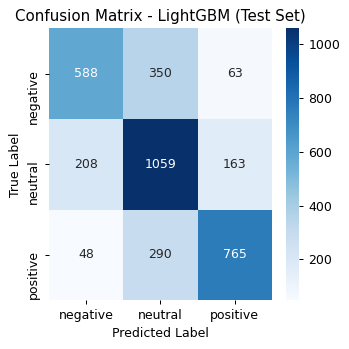

In [17]:
# list of classifiers
models = [['DummyClassifier', DummyClassifier(strategy='most_frequent', random_state=123)],
          ['LightGBM', LGBMClassifier(max_depth=8, n_estimators=300, random_state=123)]]

# loop through classifiers
for model_name, model_instance in models:
    
    # Fit the model on the training data
    model_instance.fit(x_train_concat, y_train_concat)
    
    # print scores
    print_scores(model_instance,model_name,x_train_concat,y_train_concat,x_dev_svd,[],x_test_svd,y_test)

## MLP Hyperparameter Tuning

- Before we train the MLP model, we want to optimize some of the hyperparameters
- We will tune the hyperparameters using the ***validation*** set
- Specifically, we will define a grid and try to tune the ***number of neurons*** and the ***dropout rate***
- We will use a ***RandomizedSearchCV*** function along with a $5$-fold stratified cross validation
- Finally, we will evaluate the scores obtained from cross validation using the ***F1-Score*** metric

##### *Define function to tune MLP's hyperparameters*

In [22]:
def tune_model(first_layer, second_layer, third_layer, first_dropout, second_dropout):
    model = Sequential()
    model.add(Dense(first_layer, input_dim=x_dev_svd.shape[1], activation='relu'))
    model.add(Dropout(first_dropout))
    model.add(Dense(second_layer,  activation='relu'))
    model.add(Dropout(second_dropout))
    model.add(Dense(third_layer,  activation='relu'))
    model.add(Dense(len(y_dev.unique()),  activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer = Adam(learning_rate=0.0001),
                  metrics=['sparse_categorical_accuracy'])
    return model

first_layer = [256, 128, 512]
second_layer = [256, 128, 64]
third_layer =  [128, 64, 32]
first_dropout = [0.0, 0.3, 0.5]
second_dropout = [0.0, 0.3, 0.5]

tuned_model = KerasClassifier(build_fn = tune_model, epochs=50, batch_size=64, verbose=1)

param_grid = dict(first_layer = first_layer, second_layer = second_layer, third_layer = third_layer, first_dropout=first_dropout,second_dropout=second_dropout)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

grid = RandomizedSearchCV(estimator=tuned_model
                          , param_distributions = param_grid
                          , n_jobs=-1, cv=cv, verbose=1
                          , scoring='f1_macro')

grid_result = grid.fit(x_dev_svd, y_dev)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/50
86/86 [==============================] - 1s 3ms/step - loss: 1.0947 - sparse_categorical_accuracy: 0.4049
Epoch 2/50
86/86 [==============================] - 0s 3ms/step - loss: 1.0871 - sparse_categorical_accuracy: 0.4113
Epoch 3/50
86/86 [==============================] - 0s 3ms/step - loss: 1.0810 - sparse_categorical_accuracy: 0.4099
Epoch 4/50
86/86 [==============================] - 0s 2ms/step - loss: 1.0743 - sparse_categorical_accuracy: 0.4104
Epoch 5/50
86/86 [==============================] - 0s 3ms/step - loss: 1.0657 - sparse_categorical_accuracy: 0.4142
Epoch 6/50
86/86 [==============================] - 0s 2ms/step - loss: 1.0502 - sparse_categorical_accuracy: 0.4362
Epoch 7/50
86/86 [==============================] - 0s 3ms/step - loss: 1.0240 - sparse_categorical_accuracy: 0.4981
Epoch 8/50
86/86 [==============================] - 0s 2ms/step - loss: 0.9829 - sparse_categorical_accuracy: 0.5468
Epo

In [23]:
# evaluate
best_score = grid_result.best_score_
best_params = grid_result.best_params_

# print results
print(f'Best grid score: {best_score}')
print(f'Best grid params: {best_params}', end='\n\n')

Best grid score: 0.6110482588362164
Best grid params: {'third_layer': 32, 'second_layer': 128, 'second_dropout': 0.3, 'first_layer': 128, 'first_dropout': 0.5}



##### *One-Hot Encoding*

In [20]:
lb = LabelBinarizer()
y_train_1_hot = lb.fit_transform(y_train)
y_dev_1_hot = lb.transform(y_dev)
y_test_1_hot = lb.transform(y_test)
y_train_concat_1_hot = lb.transform(y_train_concat)

##### *Metrics Definition*

In [21]:
def recall(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + backend.epsilon())
    return recall


def precision(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def accuracy(y_true, y_pred):
    return backend.mean(backend.equal(y_true, backend.round(y_pred)), axis=1)

##### *Train the MLP classifier*

In [39]:
# best model
model = Sequential()
model.add(Dense(128, input_dim=x_train_concat.shape[1] , activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,  activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32,  activation='relu'))
model.add(Dense(len(y_train.unique()),  activation='softmax'))

print(model.summary())
model.compile(loss='categorical_crossentropy',
                  optimizer = Adam(learning_rate=0.0001),
                  metrics=[precision, recall, f1, accuracy])

checkpoint = ModelCheckpoint('checkpoints/weights.hdf5',
                                 monitor='val_f1',
                                 mode='max',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=True)

my_callbacks = [
    EarlyStopping(patience=30),
    checkpoint]

history = model.fit(x_train_concat, y_train_concat_1_hot,
              validation_data=(x_test_svd, y_test_1_hot),
              batch_size=64,
              epochs=100,
              shuffle=True,
              callbacks=my_callbacks)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               256128    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 32)                4128      
                                                                 
 dense_23 (Dense)            (None, 3)                 99        
                                                                 
Total params: 276,867
Trainable params: 276,867
Non-tr

Epoch 35/100
424/430 [============================>.] - ETA: 0s - loss: 0.3154 - precision: 0.8959 - recall: 0.8797 - f1: 0.8876 - accuracy: 0.9258
Epoch 35: val_f1 did not improve from 0.70699
430/430 [==============================] - 1s 3ms/step - loss: 0.3157 - precision: 0.8958 - recall: 0.8796 - f1: 0.8876 - accuracy: 0.9258 - val_loss: 0.8731 - val_precision: 0.7035 - val_recall: 0.6888 - val_f1: 0.6960 - val_accuracy: 0.7988
Epoch 36/100
427/430 [============================>.] - ETA: 0s - loss: 0.3102 - precision: 0.8952 - recall: 0.8804 - f1: 0.8877 - accuracy: 0.9258
Epoch 36: val_f1 did not improve from 0.70699
430/430 [==============================] - 1s 3ms/step - loss: 0.3105 - precision: 0.8954 - recall: 0.8802 - f1: 0.8876 - accuracy: 0.9258 - val_loss: 0.8793 - val_precision: 0.7044 - val_recall: 0.6904 - val_f1: 0.6973 - val_accuracy: 0.7993
Epoch 37/100
419/430 [============================>.] - ETA: 0s - loss: 0.3024 - precision: 0.8993 - recall: 0.8849 - f1: 0.89

##### *Plot the curves showing the accuracy and loss on training data as a function of epochs*

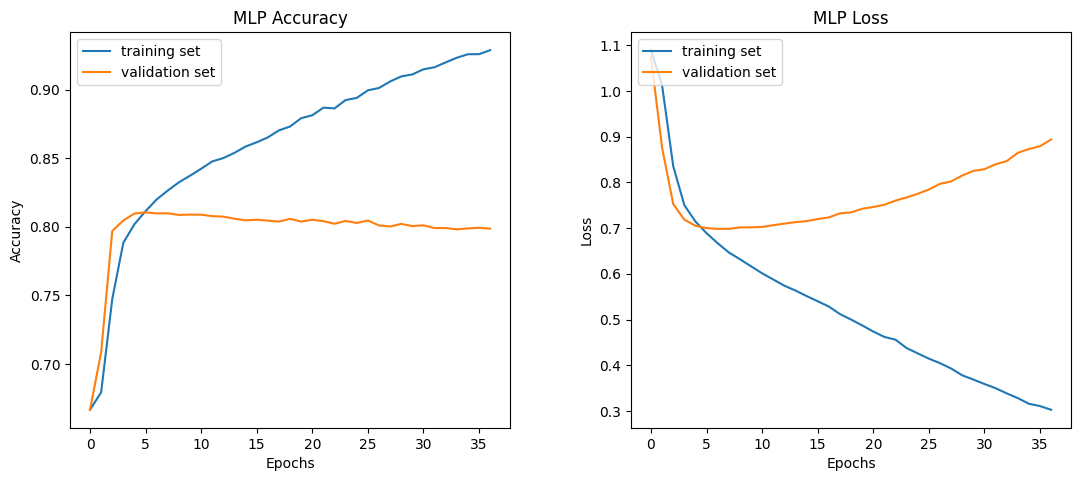

In [40]:
# create the figure
fig, ax = plt.subplots(1,2,figsize=(12,6),dpi=100,facecolor='white')

# plot the accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('MLP Accuracy')
ax[0].legend(['training set', 'validation set'], loc='upper left')

# plot the loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('MLP Loss')
ax[1].legend(['training set', 'validation set'], loc='upper left')

plt.tight_layout(pad=5)
plt.show()

##### *MLP model Performance Evaluation*

In [41]:
def print_keras_model_result(keras_model):
    predictions = keras_model.predict(x_train_concat)
    predictions_with_labels = ['negative' if index == 0 else 'neutral' if index == 1 else 'positive' for index in np.argmax(predictions,axis=1)]
    predictions_proba = np.array([[1 if index == max(row) else 0 for index in row] for row in predictions])
    scores_train = calculate_scores(y_train_concat, predictions_with_labels, predictions_proba)
    print("Trainset Results in MLP")
    print(tabulate(scores_train.round(3), headers='keys', tablefmt='psql'))
    print("="*100)

    predictions_test = keras_model.predict(x_test_svd)
    predictions_test_with_labels = ['negative' if index == 0 else 'neutral' if index == 1 else 'positive' for index in np.argmax(predictions_test,axis=1)]
    predictions_test_proba = np.array([[1 if index == max(row) else 0 for index in row] for row in predictions_test])
    scores_test = calculate_scores(y_test, predictions_test_with_labels, predictions_test_proba)
    print("Testset Results in MLP")
    print(tabulate(scores_test.round(3), headers='keys', tablefmt='psql'))
    print("="*100)
    
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, predictions_test_with_labels, labels=['negative', 'neutral', 'positive'])

    # Create heatmap
    plt.figure(figsize=(4, 4), dpi=90, facecolor='white')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'Confusion Matrix - MLP Classifier (Test Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

859/859 [==============================] - 1s 1ms/step
Trainset Results in MLP
+----------+-------------+----------+-------+-------------+
|          |   precision |   recall |    f1 |   auc_score |
|----------+-------------+----------+-------+-------------|
| positive |       0.965 |    0.965 | 0.965 |       0.301 |
| neutral  |       0.945 |    0.955 | 0.95  |       0.958 |
| negative |       0.959 |    0.946 | 0.953 |       0.288 |
| macro    |       0.957 |    0.955 | 0.956 |       0.301 |
+----------+-------------+----------+-------+-------------+
111/111 [==============================] - 0s 1ms/step
Testset Results in MLP
+----------+-------------+----------+-------+-------------+
|          |   precision |   recall |    f1 |   auc_score |
|----------+-------------+----------+-------+-------------|
| positive |       0.789 |    0.704 | 0.744 |       0.339 |
| neutral  |       0.642 |    0.722 | 0.68  |       0.724 |
| negative |       0.695 |    0.652 | 0.673 |       0.34  |
| m

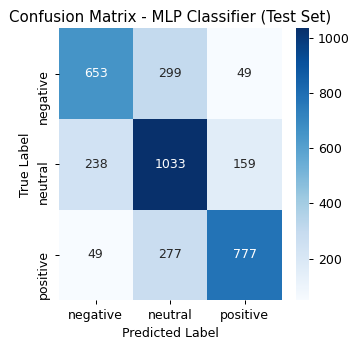

In [42]:
print_keras_model_result(model)